**TODO**
 

1.   Update the code to change the reconstruction error loss to move to mean squared error loss
2.   Change the network architecture to move to a convolutional network, adding layers. 
What is the impact on the reconstruction quality and training efficacy ?

In [160]:
#from __future__ import absolute_import
#from __future__ import division
#from __future__ import print_function

from tensorflow.keras.layers import Lambda, Input, Dense, Conv1D, Convolution1D, MaxPooling1D, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras import layers

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os


In [161]:
# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as a function of the 2D latent vector

    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    decoder, vae = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean_log, decoded = vae.predict(x_test,
                                   batch_size=batch_size)
    print('z_mean_log.shape', z_mean_log.shape)
    print('decoded.shape', decoded.shape)

    z_mean=z_mean_log[:,:2]
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.title('Scatterplot of the images in the latent space; Each color correspond to a digit')
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    count=0
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            #print('x_decoded.shape',x_decoded.shape)
            digit = x_decoded.reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit
            count+=1
    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

In [162]:
batch_size = 128
# MNIST dataset
#-> load numpy data and set shapes
(x_train, y_train), (x_test, y_test) = mnist.load_data()
image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
data_test=(x_test, y_test) #will be used in the end to plot results

#-> define data pipelines with a specific function that customises each sample
#-> here, for each sample, define one label for each model output
print('NUMPY x_train.shape',x_train.shape)
def prepare_data(sample):
  ''' post-process each sample individually
      Args:
        sample : the input sample (singe one)
      Returns:
        sample: the data sample that will feed the model
        dict: a dictionnary of labels, with keys corresponding to the model output names
  '''
  sample = tf.cast(sample, dtype=tf.float32) / 255.

  return sample, {'enc_out':tf.constant(0.), 'dec_out':sample}

x_train_pipeline = tf.data.Dataset.from_tensor_slices(x_train)
x_train_pipeline = x_train_pipeline.map(prepare_data)
x_train = x_train_pipeline.batch(batch_size).prefetch(1)
print('x_train_pipeline',x_train_pipeline)

x_test_pipeline = tf.data.Dataset.from_tensor_slices(x_test)
x_test_pipeline = x_test_pipeline.map(prepare_data)
x_test = x_test_pipeline.batch(batch_size).prefetch(1)
print('x_test_pipeline',x_train_pipeline)


NUMPY x_train.shape (60000, 784)
x_train_pipeline <MapDataset shapes: ((784,), {enc_out: (), dec_out: (784,)}), types: (tf.float32, {enc_out: tf.float32, dec_out: tf.float32})>
x_test_pipeline <MapDataset shapes: ((784,), {enc_out: (), dec_out: (784,)}), types: (tf.float32, {enc_out: tf.float32, dec_out: tf.float32})>


In [163]:
# network parameters
from keras.layers import Concatenate
input_shape = (original_dim,)
intermediate_dim = 512
latent_dim = 2
epochs = 8

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')

img_input = layers.Input(shape=(image_size, image_size, 9))

x = Dense(intermediate_dim, activation='relu')(inputs)
#on reshape au sein du modèle pour ne pas casser le fonctionnement global du modèle (shape des data d'entre, etc.)
x = tf.keras.layers.Reshape((intermediate_dim,1))(x)
""" x = Conv1D(1,3, activation='relu')(x)
x = MaxPooling1D(2)(x)

x = Conv1D(2,3, activation='relu')(x)
x = MaxPooling1D(2)(x)

x = Conv1D(4,3, activation='relu')(x)
x = MaxPooling1D(2)(x)

x = Conv1D(8,3, activation='relu')(x)
x = MaxPooling1D(2)(x) """

#print('x_conv', x)

x=tf.keras.layers.Flatten()(x) #on en a besoin pour remettre le tenseur en 1D [batch, sequence]
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

z_mean_log = Concatenate(name='enc_out',axis=-1)([z_mean ,z_log_var])
print('z_mean_log',z_mean_log)
# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean_log, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = encoder.outputs[1]#Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)

x = tf.keras.layers.Reshape((intermediate_dim,1))(x)

x = Conv1D(1,3, activation='relu')(x)

x=tf.keras.layers.Flatten()(x)

recons = Dense(510, activation='sigmoid', name='dec_out')(x)

# instantiate decoder model
#decoder = Model(latent_inputs, recons, name='decoder')
#decoder.summary()
#plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# instantiate VAE model
vae = tf.keras.Model(encoder.input, outputs=[encoder.outputs[0], recons], name='vae_mlp')


z_mean_log KerasTensor(type_spec=TensorSpec(shape=(None, 4), dtype=tf.float32, name=None), name='enc_out/concat:0', description="created by layer 'enc_out'")
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_53 (Dense)                (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
reshape_20 (Reshape)            (None, 512, 1)       0           dense_53[0][0]                   
__________________________________________________________________________________________________
flatten_25 (Flatten)            (

Model: "vae_mlp"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_53 (Dense)                (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
reshape_20 (Reshape)            (None, 512, 1)       0           dense_53[0][0]                   
__________________________________________________________________________________________________
flatten_25 (Flatten)            (None, 512)          0           reshape_20[0][0]                 
____________________________________________________________________________________________

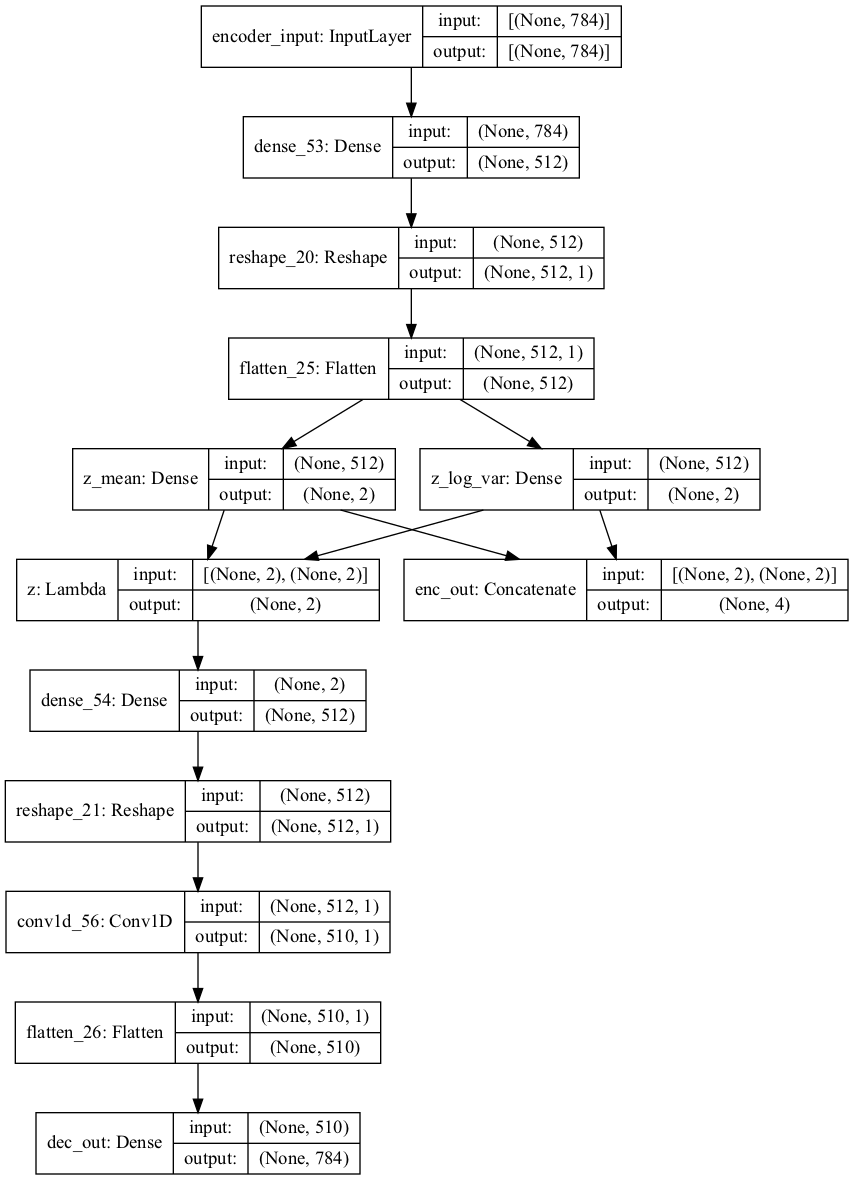

In [164]:
import tensorflow as tf
def getloss():
  ''' we define all the required loss functions, one for each model output
  return a dictionnary with key-values : model_output_name:loss function ''' 
  def loss_cod(y_true,y_pred):
    z_mean , z_log_var = tf.split(y_pred,num_or_size_splits=2, axis=-1)
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    return kl_loss				
  def loss_rec(y_true,y_pred):
    recons_loss = tf.reduce_mean(tf.square(y_true - y_pred),axis=-1)
    recons_loss = tf.reduce_mean(recons_loss)
    return recons_loss*784				
  loss_dict = {'enc_out':loss_cod,'dec_out':loss_rec}
  return loss_dict  
vae.compile(optimizer='adam',loss=getloss())
vae.summary()

dot_img_file = 'vae_mlp.png'
tf.keras.utils.plot_model(vae, to_file='vae_mlp.png', show_shapes=True)

In [165]:
vae.fit(x_train,epochs=epochs, batch_size=batch_size, validation_data=x_test)
vae.save_weights('vae_mlp_mnist.h5')

Epoch 1/8
469/469 [==============================] - 6s 12ms/step - loss: 74.1303 - enc_out_loss: 5.0552 - dec_out_loss: 69.0751 - val_loss: 44.6632 - val_enc_out_loss: 2.6856 - val_dec_out_loss: 41.9776
Epoch 2/8
469/469 [==============================] - 6s 12ms/step - loss: 43.9933 - enc_out_loss: 2.9147 - dec_out_loss: 41.0785 - val_loss: 42.8689 - val_enc_out_loss: 3.1484 - val_dec_out_loss: 39.7205
Epoch 3/8
469/469 [==============================] - 6s 13ms/step - loss: 42.3523 - enc_out_loss: 3.3492 - dec_out_loss: 39.0032 - val_loss: 41.7088 - val_enc_out_loss: 3.5716 - val_dec_out_loss: 38.1372
Epoch 4/8
469/469 [==============================] - 6s 12ms/step - loss: 41.2094 - enc_out_loss: 3.6302 - dec_out_loss: 37.5793 - val_loss: 40.8322 - val_enc_out_loss: 3.7149 - val_dec_out_loss: 37.1172
Epoch 5/8
469/469 [==============================] - 6s 13ms/step - loss: 40.3651 - enc_out_loss: 3.8663 - dec_out_loss: 36.4989 - val_loss: 40.0867 - val_enc_out_loss: 3.9842 - val_de

In [166]:
#FIXME : pour ploter la grille de valeurs, il faudrait le modèle du décodeur... et on ne l'a plus...par transfer/copie des poids ?
# build decoder model SAME as the VAE decoding part
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
recons = Dense(original_dim, activation='sigmoid', name='dec_out')(x)
decoder=tf.keras.Model(inputs=latent_inputs, outputs=recons)
# copy weights...  there should be an easier way
''' uncomment to check model layers details:
print('*** vae structure')
for layer in vae.layers:
  print(layer)
print('*** new decoder structure')
for layer in decoder.layers:
  print(layer)
print(vae.layers[-3].weights[0].shape)
print(vae.layers[-3].weights[0].shape) #première couche dense 2->512
print(vae.layers[-1].weights[0].shape) #seconde couche dense 512->784
print(decoder.layers[-2].weights[0].shape) #première couche dense 2->512
print(decoder.layers[-1].weights[0].shape) #seconde couche dense 512->784
'''
#copy weights AND bias
decoder.layers[-11].set_weights(vae.layers[-11].get_weights())
decoder.layers[-1].set_weights(vae.layers[-1].get_weights())

#send to the plotter
models=(decoder, vae)
plot_results(models,data_test,batch_size=batch_size,model_name="vae_mlp")

ValueError: Layer weight shape (512, 784) not compatible with provided weight shape (510, 784)